<a href="https://colab.research.google.com/github/choderalab/pinot/blob/master/scripts/fixed_vs_trainable_sigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! rm -rf pinot
! git clone https://github.com/choderalab/pinot.git
! pip install dgl
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.append('/content/pinot/')
import pinot
import dgl
import torch
import numpy
import matplotlib

Cloning into 'pinot'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 938 (delta 23), reused 36 (delta 5), pack-reused 859
Receiving objects: 100% (938/938), 154.84 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (324/324), done.
     |████████████████████████████████| 3.0MB 2.8MB/s 
--2020-04-30 01:33:15--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-30 01:33:15--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [0]:
ds = pinot.data.esol()
ds = pinot.data.utils.batch(ds, 32)
ds_tr, ds_te = pinot.data.utils.split(ds, [4, 1])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


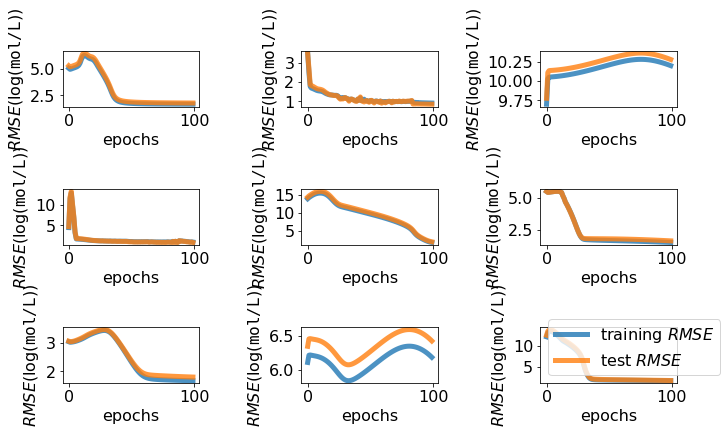

In [0]:
plt.figure(figsize=(10, 6))
for idx in range(9):

    net_representation = pinot.representation.Sequential(
        pinot.representation.dgl_legacy.GN,
        [32, 'tanh', 32, 'tanh', 32, 'tanh'])
    net_regression = pinot.regression.Linear(32, 2)
    net_trainable_sigma = pinot.Net(
        net_representation, net_regression,
        param_transform=(lambda mu, sigma: (mu, torch.exp(sigma) + 1e-3)),)
    opt = torch.optim.Adam(net_trainable_sigma.parameters(), 1e-3)
    import numpy as np
    loss_fn = torch.nn.functional.mse_loss

    rmse_tr = []
    rmse_te = []
    for _ in range(100):
        for g, y in ds_tr:
            opt.zero_grad()
            loss = torch.sum(net_trainable_sigma.loss(g, y))
            loss.backward()
            opt.step()

        rmse_tr.append(np.mean([np.sqrt(loss_fn(y, net_trainable_sigma.expectation(g)).detach().numpy()) for g, y in ds_tr]))
        rmse_te.append(np.mean([np.sqrt(loss_fn(y, net_trainable_sigma.expectation(g)).detach().numpy()) for g, y in ds_te]))

    import matplotlib
    from matplotlib import pyplot as plt
    plt.subplot(3, 3, idx+1)
    # plt.rc('font', size=16) 
    plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
    plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
    plt.xlabel('epochs')
    plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()

plt.tight_layout()

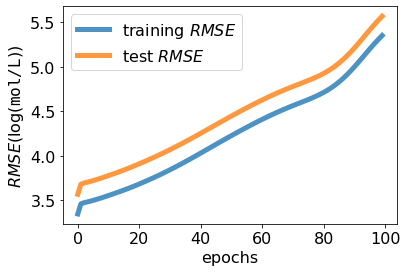

In [0]:
import matplotlib
from matplotlib import pyplot as plt
plt.rc('font', size=16) 
plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
plt.xlabel('epochs')
plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()